# __9 Wrap up__

Goal:
- Tie the loose ends

## ___Setup___

### Module import

In conda env `base`

In [63]:
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.misc import derivative
from datetime import datetime
from tqdm import tqdm

### Key variables

In [20]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "9_wrap_up"
work_dir.mkdir(parents=True, exist_ok=True)

# text classify
dir2 =  proj_dir / "2_text_classify"

# plant science corpus with topic assignment info
dir42      = proj_dir / "4_topic_model/4_2_outlier_assign"
corpus_file = dir42 / "table4_2_corpus_with_topic_assignment.tsv.gz"
#corpus_file = dir42 / "test.tsv"

# over time
dir44         = proj_dir / "4_topic_model/4_4_over_time"
dir_lowess    = dir44 / "_lowess"
top_freq_file = dir44 / 'table4_4c_topic_frequency_per_timestamp.txt'

# country info, pmid, ...
dir75             = proj_dir / "7_countries/7_5_country_over_time"
ci_file           = dir75 / 'ci_pmid_topic.tsv'
c_npub_file       = dir75 / 'country_npub_raw.csv'
t25_toc_stat_file = dir75 / "country_top25_toc_stat.csv"

# SJR and pdjity (pmid, date, journal, issn, topic, year)
dir81            = proj_dir / '8_impact/8_1_topic'
pdjity_file      = dir81 / "table_pdjity.tsv"
file_d_d_metric  = dir81 / 'sjr_metric_dicts.pkl'

# So PDF is saved in a format properly
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "sans-serif"

## ___Finalize pub number graphs___

### Pub number graph after removing China

Related graphs:
- 1_1: number pubs per year in pubmed
- 4_4: number pubs per year in plant science corpus

Focus on 1951 to 2020

In [16]:
file_docs_year_df = dir44 / "table_4_4_docs_year_df.csv"
docs_year_df = pd.read_csv(file_docs_year_df, index_col=0).drop(2021)
docs_year_df.iloc[-2:]

,Count
2019,26963
2020,30228


In [21]:
# Get pub number for CHN
file_c25_year_count = dir75 / "country_top25_year_count.csv"
c25_year_count = pd.read_csv(file_c25_year_count, index_col=0)
pub_num_CHN    = c25_year_count.loc["CHN"]

# convert to dictionary, note that the indices are strings, need to be integer
pub_num_CHN_dict = {int(k):v for k,v in pub_num_CHN.items()}

pub_num_CHN['2019'], pub_num_CHN_dict[2019]

(7869, 7869)

In [15]:
# add missing years
pub_num_CHN_list = []
for yr in docs_year_df.index:
  if yr in pub_num_CHN_dict:
    pub_num_CHN_list.append(pub_num_CHN_dict[yr])
  else:
    pub_num_CHN_list.append(0)

docs_year_df.shape, len(pub_num_CHN_list)

((96, 2), 96)

In [17]:
### Substract CHN from total then add to df 
docs_year_df["CHN"] = pub_num_CHN_list
docs_year_df.head(2)

,Count,CHN
1917,1,0
1918,1,0


In [20]:
docs_year_df['Count_no_CHN'] = docs_year_df['Count'] - docs_year_df['CHN']
docs_year_df.head(2), docs_year_df.tail(2)

(      Count  CHN  Count_no_CHN
 1917      1    0             1
 1918      1    0             1,
       Count   CHN  Count_no_CHN
 2019  26963  7869         19094
 2020  30228  9031         21197)

In [27]:
target_yrs = [y for y in range(1951, 2021)]

docs_year_df_part = docs_year_df.loc[target_yrs]
docs_year_df_part.head(2), docs_year_df_part.tail(2)

(      Count  CHN  Count_no_CHN
 1951      2    0             2
 1952      2    0             2,
       Count   CHN  Count_no_CHN
 2019  26963  7869         19094
 2020  30228  9031         21197)

In [28]:
### Plot exponential fit

X = docs_year_df_part.index
Y = docs_year_df_part["Count_no_CHN"].values

def exp_func(X, a, b, c):
  return a*np.exp(b*X) + c

# Curve fit
popt_exp, _ = curve_fit(exp_func, X, Y, p0=(1, 1e-6, 1), maxfev=10000)
popt_exp

array([ 1.97174697e-41,  5.13730308e-02, -1.24134120e+03])

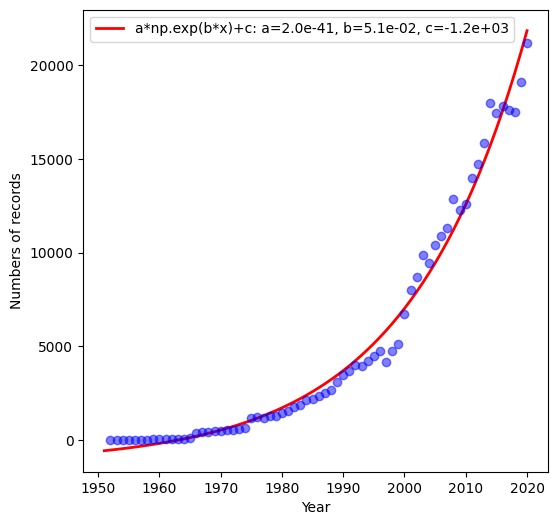

In [30]:
# Plotting
fig_fit_yr_docnum = work_dir / "fig_9_year_docnum_noCHN_exponential_fit.pdf"

#y_pred = [exp_func(x, *popt_exp) for x in X]
plt.figure(figsize=(6, 6))

# plot legend in scientific number:
#https://www.scaler.com/topics/python-scientific-notation/
#https://sparrow.dev/python-scientific-notation/

plt.plot(X, exp_func(X, *popt_exp),'r',linewidth=2, 
        label='a*np.exp(b*x)+c: a=%.1e, b=%.1e, c=%.1e' % tuple(popt_exp))
plt.plot(X[1:], Y[1:], 'bo', alpha=0.5)
#plt.plot(x[1:], y_pred[1:], '-b')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Numbers of records")
plt.savefig(fig_fit_yr_docnum, format='pdf')
plt.show()

## ___Table S1___

Turn out_raw_journal_counts into a table

In [38]:
jcount_file = dir2 / "out_raw_journal_counts"
jcount_tsv  = dir2 / "out_raw_journal_counts.tsv"

In [40]:
jcount_file

PosixPath('/home/shius/projects/plant_sci_hist/2_text_classify/out_raw_journal_counts')

In [43]:
# Split based on the last "," then output as a file
jcount_list = []
with open(jcount_file) as f:
  jcounts = f.readlines()
  for jc in jcounts:
    j = jc[:jc.rfind(",")]
    c = jc[jc.rfind(",")+1:]
    jcount_list.append([j,c])

with open(jcount_tsv, "w") as f:
  for jc in jcount_list:
    f.write(jc[0] + "\t" + jc[1])


## ___Chosing articles for select topic in specific years___

### Read corpus with topiv assignment

In [8]:
corpus_df = pd.read_csv(corpus_file, sep='\t', compression='gzip', index_col=0)

In [9]:
corpus_df.head(2)

,Index_1385417,PMID,Date,Journal,Title,Abstract,Initial filter qualifier,Corpus,reg_article,Text classification score,Preprocessed corpus,Topic
0,3,61,1975-12-11,Biochimica et biophysica acta,Identification of the 120 mus phase in the dec...,After a 500 mus laser flash a 120 mus phase in...,spinach,Identification of the 120 mus phase in the dec...,1,0.716394,identification 120 mus phase decay delayed flu...,52
1,4,67,1975-11-20,Biochimica et biophysica acta,Cholinesterases from plant tissues. VI. Prelim...,Enzymes capable of hydrolyzing esters of thioc...,plant,Cholinesterases from plant tissues. VI. Prelim...,1,0.894874,cholinesterases plant tissues . vi . prelimina...,48


In [22]:
# Add the year column
dates = corpus_df.Date.values
years = [int(date.split('-')[0]) for date in dates]

corpus_df["Year"] = years

### Function to get specific topic/year range dataframe

In [57]:
def get_df_toc_years(df, toc, y_begin, y_end):
  '''
  Args:
    df (pd.DataFrame): corpus_df with Year column
    toc (dict): table of contents
    y_begin (int): begin year, inclusive
    y_end (int): end year, inclusive
  Output:
    df_toc_years (csv)
  '''

  cond1 = corpus_df['Topic'] == toc
  cond2 = corpus_df['Year'].isin(range(y_begin, y_end+1))

  df_toc_years =  corpus_df[cond1 & cond2]

  df_toc_years.to_csv(work_dir / f'table_9_corpus_toc{toc}_yr{y_begin}-{y_end}.csv', 
                      index=False)

  return df_toc_years


### Topic 78, year 1998, 1999, 2000

In [58]:
df_toc78 = get_df_toc_years(corpus_df, 78, 2000, 2002)
df_toc78.shape

(103, 13)

### Topic 44, year 1917-1977

In [60]:
df_toc44 = get_df_toc_years(corpus_df, 44, 1917, 1977)
df_toc44.shape

(1223, 13)

## ___Major down/up-ward trends per time point___

- In section 4_4c
  - I have played with quite a few different ways to predict trends.
  - But the predicted trend lines looks suspicious and unexpected so did not adopt them.
  - End up using Lowess fit.
- In section 4_4d
  - I have further picked the best fiting lowess models for each topic.
  - The fit is saved as pickle for each topic.
  - Have experimented with ways to define major transition. But at the time, I tried to do this per topic and encountered issues with topics that have multiple peaks.
- Once I finished discussing Figure 3 
  - Realize that there are 3 major transitions:
  - Also realize that I should have a measure to estimate "transition".

Define transition point: time points with among the highest degree of 
- downward trend
- upward trend
- In both cases, use the slope of lowess fit at that time point as measure
  - Separate positive and negative values for up and downward trends, respectively.
  - Set a threshold and get the average of slopes above threshold
    - Want to ignore slopes ~0 because they only make the sum look smaller than it really is.

For getting slope:
- https://stackoverflow.com/questions/30309557/how-to-get-derivatives-from-1d-interpolation




### Reading lowess fit obj and get info out

In [52]:
# Load topic frequency for each timestamp
top_freq_df = pd.read_csv(top_freq_file, index_col=0)
topics      = top_freq_df.index.tolist()              # topic list
toc_series  = top_freq_df.loc[0]                      # topic frequency series
                                                      # same for all topics
ts_list     = [float(ts) for ts in toc_series.index]  # timestamps
ts0 = ts_list[0]                                      # first timestamp
ts1 = ts_list[-1]                                     # last timestamp

# Start from 1978 to 2020
datetime.fromtimestamp(ts0), datetime.fromtimestamp(ts1)

(datetime.datetime(1977, 12, 11, 23, 59, 59),
 datetime.datetime(2021, 1, 1, 0, 0))

In [91]:
# Get lowess pickles
lowess_pickles = list(dir_lowess.glob('**/*.pickle'))
lowess_pickles

[PosixPath('/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic-1_frac0.1.pickle'),
 PosixPath('/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic-1_frac0.2.pickle'),
 PosixPath('/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic-1_frac0.3.pickle'),
 PosixPath('/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic0_frac0.1.pickle'),
 PosixPath('/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic0_frac0.2.pickle'),
 PosixPath('/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic0_frac0.3.pickle'),
 PosixPath('/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic10_frac0.1.pickle'),
 PosixPath('/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic

In [123]:
# derivative(f, x0, dx) = (f(x0+dx) - f(x0-dx)) / (2 * dx)
# dx is set to 1 week = 7*24*60*60 seconds
dx = 7*24*60*60 

# Create {topic: {frac_param: {year: slope}}} for record-keeping
toc_slopes = {}

# Create {year: {frac_param: [slopes]}} to detect shifts
yr_slopes = {}

# For each topic
for pkl in lowess_pickles:
  # file name: lowess_fit_func_topicX_fracX.X.pickle
  f_name = str(pkl).split("/")[-1]
  # get topic index
  topic = f_name.split("_")[3][5:]
  # get fraction parameter
  frac = f_name.split("_")[4].split(".pickle")[0][4:]

  if topic not in toc_slopes:
    toc_slopes[topic] = {frac: {}}
  else:
    toc_slopes[topic][frac] = {}

  # Checked and confirmed that the topic and frac are correct
  #print(f_name, topic, frac)

  # read lowess fit
  with open(pkl, 'rb') as f:
    lowess_fit = pickle.load(f)


  # Start from 1978 to 2020, do it every year
  for yr in range(1978, 2021):
    x0 = datetime(yr, 1, 1).timestamp()
    # Slope very small because the scale for x is very large compare to y
    slope =  derivative(lowess_fit, x0, dx)

    toc_slopes[topic][frac][yr] = slope

    if yr not in yr_slopes:
      yr_slopes[yr] = {frac: [slope]}
    elif frac not in yr_slopes[yr]:
      yr_slopes[yr][frac] = [slope]
    else:
      yr_slopes[yr][frac].append(slope)

In [124]:
# Save toc_slopes and year_slopes as pickles
with open(work_dir / 'dict_toc_frac_year_lowess_slopes.pkl', 'wb') as f:
  pickle.dump(toc_slopes, f)

with open(work_dir / 'dict_year_frac_lowess_slopes.pkl', 'wb') as f:
  pickle.dump(yr_slopes, f)

In [128]:
# Create a dataframe with yr_slope_sum, 7 columns:
#  year
#  frac_param_0.1_positive
#  frac_param_0.2_positive
#  frac_param_0.3_positive
#  frac_param_0.1_negative
#  frac_param_0.2_negative
#  frac_param_0.3_negative
# yr_slope_sum = {year: {frac_param: sum_of_slopes_over_all_topics}}

years = range(1978, 2021)

# List of lists
# [fc01_pos, fc01_neg, fc02_pos, fc02_neg, fc03_pos, fc03_neg]
fc_slopes = [[], [], [], [], [], []]

# frac_param correspond to fc_slope indices
fc_idx = {"0.1":[0,1], "0.2":[2,3], "0.3":[4,5]}
for yr in years:
  for fc in fc_idx:
    # yr_slope_sum = {year: {frac_param: [slopes]}}

    # positive and negative slope sums
    sum_p = sum_n = 0
    for slope in yr_slopes[yr][fc]:
      if slope > 0:
        sum_p += slope
      elif slope < 0:
        sum_n += slope

    # append to fc_slopes
    fc_slopes[fc_idx[fc][0]].append(sum_p)
    fc_slopes[fc_idx[fc][1]].append(sum_n)

df_slope_sum = pd.DataFrame({'Year': years, 
                             'frac0.1_pos': fc_slopes[0], 
                             'frac0.1_neg': fc_slopes[1],
                             'frac0.2_pos': fc_slopes[2],
                             'frac0.2_neg': fc_slopes[3],
                             'frac0.3_pos': fc_slopes[4],
                             'frac0.3_neg': fc_slopes[5],})

In [129]:
df_slope_sum.head(10)

,Year,frac0.1_pos,frac0.1_neg,frac0.2_pos,frac0.2_neg,frac0.3_pos,frac0.3_neg
0,1978,0.000008,-0.000007,0.000006,-0.000007,0.000005,-0.000006
1,1979,0.000008,-0.000007,0.000006,-0.000007,0.000005,-0.000006
2,1980,0.000008,-0.000007,0.000006,-0.000007,0.000005,-0.000006
3,1981,0.000008,-0.000007,0.000006,-0.000007,0.000005,-0.000006
4,1982,0.000008,-0.000007,0.000006,-0.000007,0.000005,-0.000006
5,1983,0.000008,-0.000007,0.000006,-0.000007,0.000005,-0.000006
6,1984,0.000008,-0.000007,0.000006,-0.000007,0.000005,-0.000006
7,1985,0.000008,-0.000007,0.000006,-0.000007,0.000005,-0.000006
8,1986,0.000008,-0.000007,0.000006,-0.000007,0.000005,-0.000006
9,1987,0.000008,-0.000007,0.000006,-0.000007,0.000005,-0.000006


In [132]:
df_slope_sum.to_csv(work_dir / 'table_year_frac_slope_sum.csv', index=False)

## ___Testing___

### Condition to get specific rows

In [ ]:
cond1 = (corpus_df['Topic'] == 78)
cond1.values.sum()

1364

In [ ]:
cond2 = corpus_df['Year'].isin(range(2000, 2002))
cond2.values.sum()

14994

In [ ]:
(cond1 & cond2).values.sum()

72

In [ ]:
corpus_df[cond1 & cond2].shape

(72, 13)

### Lowess fit derivatives

In [133]:
def get_file(toc, frac):
  fit_pkl = ""
  for pkl in lowess_pickles:
    file = str(pkl).split("/")[-1]
    if file.find(f"topic{toc}_frac{frac}") != -1:
      fit_pkl = pkl
      break
  
  return fit_pkl

In [140]:
fit_pkl = get_file(40, 0.2)
with open(fit_pkl, 'rb') as f:
  lowess_fit = pickle.load(f)

In [141]:
# Start from 1978 to 2020, do it every year
for yr in range(1978, 2021):
  x0 = datetime(yr, 1, 1).timestamp()
  # Slope very small because the scale for x is very large compare to y
  slope = "{:.2e}".format(derivative(lowess_fit, x0, dx))
  print(yr, slope)

1978 4.26e-08
1979 4.26e-08
1980 4.26e-08
1981 4.26e-08
1982 4.26e-08
1983 4.26e-08
1984 4.24e-08
1985 4.24e-08
1986 4.24e-08
1987 4.24e-08
1988 5.07e-08
1989 5.07e-08
1990 5.07e-08
1991 6.76e-08
1992 6.76e-08
1993 7.02e-08
1994 7.02e-08
1995 5.62e-08
1996 5.62e-08
1997 1.37e-08
1998 1.37e-08
1999 7.38e-09
2000 7.38e-09
2001 3.74e-08
2002 1.73e-08
2003 -1.71e-08
2004 1.77e-08
2005 -1.48e-08
2006 -4.28e-08
2007 -3.53e-08
2008 -7.57e-08
2009 -5.40e-08
2010 -3.48e-08
2011 9.35e-09
2012 7.47e-08
2013 9.98e-08
2014 1.48e-07
2015 1.62e-07
2016 2.28e-07
2017 1.86e-07
2018 1.97e-07
2019 9.76e-08
2020 -1.06e-08


In [142]:
lowess_fit

In [143]:
ts_list[1]/1e8

4.25879999

In [144]:
def plot_fit(lowess_fit, ts_list):
  x = np.arange(ts_list[0], ts_list[-1], 1e7)
  y = lowess_fit(x)
  plt.plot(x, y, '-')

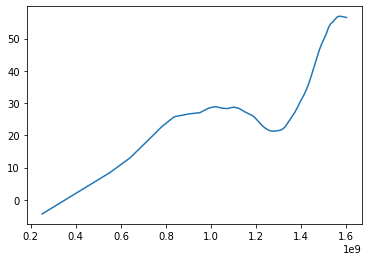

In [145]:
plot_fit(lowess_fit, ts_list)

In [ ]:
def get_slopes(fp, yr):
  slopes = []
  for toc in toc_slopes:
    # toc_slopes = {topic: {frac_param: {year: slope}}}
    slope = toc_slopes[toc][fp][yr]
    slopes.append(slope)

  print(slopes)
  print(np.sum(slopes))

In [ ]:
get_slopes("0.1", 1978)


[-1.5585835479923253e-07, 8.007666046275657e-08, 1.8787624903103298e-08, 2.2878605603393256e-08, 5.719720523543507e-07, 5.081782505524478e-10, 2.906040826115834e-09, 3.559440197855734e-08, 1.1403433909935537e-08, 4.470442650206532e-09, 4.339653238866233e-07, 1.2248659900720465e-08, 3.5291523439754113e-07, 7.966509912475904e-08, -6.885449563516242e-09, -3.3689413301720187e-07, 5.238299128650375e-10, -5.015124932035659e-10, 2.0710684494913193e-08, 8.309496778026117e-09, 2.1912522569169244e-08, 0.0, 8.514809828008411e-09, -3.11186378328969e-10, 1.2068593575248495e-09, 3.434126072774559e-08, 4.61736034683397e-07, 3.0023208696777672e-09, 4.606680388152597e-09, 1.3780948534538606e-06, 1.478025828707789e-08, 1.1420140102278845e-08, 1.255612933323106e-07, 3.628658805493787e-07, -4.187018490554766e-09, 1.0999046190035812e-08, 9.229088077809965e-09, -3.074222462742701e-09, -7.778365894277865e-08, -1.595987232101955e-06, -3.0605975474107145e-06, 8.503464593271649e-08, 1.365292512632837e-07, 1.004

In [ ]:
get_slopes("0.1", 1982)

[-1.5585835479913853e-07, 8.00766604627551e-08, 1.8787624903103665e-08, 2.2878605603393256e-08, 5.719720523543566e-07, 5.081782505524536e-10, 2.9060408261154666e-09, 3.559440197855807e-08, 1.1403433909935904e-08, 4.470442650206509e-09, 4.339653238865763e-07, 1.2248659900720465e-08, 3.5291523439754113e-07, 7.966509912475904e-08, -6.885449563516334e-09, -3.3689413301720187e-07, 5.238299128650317e-10, -5.015124932028315e-10, 2.071068449491246e-08, 8.309496778026484e-09, 2.1912522569169333e-08, 0.0, 8.514809828008365e-09, -3.11186378328969e-10, 1.2068593575248036e-09, 3.434126072774632e-08, 4.617360346834029e-07, 3.0023208696777672e-09, 4.606680388152597e-09, 1.3780948534538314e-06, 1.478025828707789e-08, 1.1420140102278478e-08, 1.2556129333231207e-07, 3.6286588054937795e-07, -4.187018490554399e-09, 1.0999046190035812e-08, 9.229088077809965e-09, -3.074222462742701e-09, -7.77836589427669e-08, -1.595987232101955e-06, -3.0605975474107145e-06, 8.503464593271649e-08, 1.365292512632837e-07, 1.00